In [1]:
### 0. Import libraries
from dateutil import tz
from datetime import datetime,date
import timestring
import time
import os
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
# This allows plots to appear on the IPython notebook.
%matplotlib inline
import matplotlib.cm as cm # import the colormap library
import operator
import math
import json
import networkx as nx

In [2]:
### 1. Re-read the Trips Dictionary by json library
Trips = json.load(open("Trips.txt"), "utf-8")

### 1. Construct the Riyadh Road Network graphic RG
## 1.1 Define an empty undirected graph "RG" to store the road network data
RG = nx.Graph()
## 1.2 Read dataframe "route_edges_am"
edge_df = pd.read_csv("RiyadhRoad/data/riyadh_route_edges_am.txt", sep=" ", index_col=0)
# Define the values dictionary for the "edge attributes"
keys = ['volume', 'capacity', 'voc', 'degree', 'free_travel_time', 'travel_time']
for row in edge_df.itertuples(index=False):    
    values = row[2:]    
    # We create a dictionary "edge_attributes" with the keys and row values
    edge_attributes = dict(zip(keys, values))    
    my_tuple = (row[0], row[1])   
    # We add the edge to the graph use "add_edge" function
    RG.add_edge(*my_tuple, attr_dict=edge_attributes)
## 1.3 Read and Add coordinates to nodes of graphic RG
nodes_df = pd.read_csv("RiyadhRoad/data/riyadh_nodes.txt", sep=" ", index_col=0)
nodes_df.head(2)
for node_id in RG.nodes():
    RG.node[node_id]["coordinate"] = (nodes_df['st_x'][node_id], nodes_df['st_y'][node_id])
loc_dict = {}
for node_index in RG.nodes():
    ##print node_index
    loc_dict[node_index] = RG.node[node_index]["coordinate"]
## 1.4 Check if the network is connected?
print "** Is the road network connected? "+ str(nx.is_connected(RG))
print '**',RG.node[1]['coordinate']

** Is the road network connected? True
** (46.849302248324101, 24.701475446932697)


In [3]:
print Trips['1']

{u'TimeInDay': 0.416, u'TripID': 1, u'sumTime': 2.63, u'Gender': u'female', u'D_node': 2653, u'O_node': 3890, u'Cost': 12.25, u'Trip_Minutes': 6.0, u'path': [3890, 67, 382, 873, 10349, 7821, 8262, 945, 7226, 745, 746, 9850, 848, 849, 2653]}


In [4]:
### 2. Constructed the Shareability graph, using nodes for trips and edges for shared trips
rideshare_RG = nx.Graph()
## Define the acceptable delayed time
DELTA = 5.0
DELTA2 = 0.0035*2 # 5 minutes in a day format, 5/24*60
process={}
for i in Trips.keys():
    #print i
    o1=Trips[i]['O_node']
    d1=Trips[i]['D_node']
    T_i=Trips[i]['sumTime']
    time1=Trips[i]['TimeInDay']
    list_j = []
    list_j1 = []
    list_j2 = []
    for j in Trips.keys():
        if i != j and j >i:
            dict_T = {}
            dict_Nodes = {}
            time2=Trips[j]['TimeInDay']
            ## Select trips that are closer in 5 minutes
            if abs(time2-time1)<DELTA2:
                list_j.append(j)
                #print len(list_j)
                import gpxpy.geo            
                o2=Trips[j]['O_node']
                d2=Trips[j]['D_node']
                lat_o1=RG.node[o1]['coordinate'][1]
                lon_o1=RG.node[o1]['coordinate'][0]
                lat_o2=RG.node[o2]['coordinate'][1]
                lon_o2=RG.node[o2]['coordinate'][0]
                dist_o = gpxpy.geo.haversine_distance(lat_o1, lon_o1, lat_o2, lon_o2)
                lat_d1=RG.node[d1]['coordinate'][1]
                lon_d1=RG.node[d1]['coordinate'][0]
                lat_d2=RG.node[d2]['coordinate'][1]
                lon_d2=RG.node[d2]['coordinate'][0]
                dist_d = gpxpy.geo.haversine_distance(lat_d1, lon_d1, lat_d2, lon_d2)
                #print dist_o, dist_d, RG.node[o1]['coordinate'],RG.node[o2]['coordinate']
                if dist_o < 3000 or dist_d < 3000:
                    list_j1.append(j)
                    #print len(list_j1)
                    list_j.append(j)
                    dict_Nodes['o1']=o1
                    dict_Nodes['o2']=o2
                    dict_Nodes['d1']=d1
                    dict_Nodes['d2']=d2                        
                    T_j=Trips[j]['sumTime']
                    # use nx.dijkstra_path_length(RG,O,D,weithg = '') to return added up value directly
                    t1 = nx.dijkstra_path_length(RG, o1, o2, weight='travel_time')
                    t2 = nx.dijkstra_path_length(RG, o1, d1, weight='travel_time')
                    t3 = nx.dijkstra_path_length(RG, o1, d2, weight='travel_time')
                    t4 = nx.dijkstra_path_length(RG, o2, d1, weight='travel_time')
                    t5 = nx.dijkstra_path_length(RG, o2, d2, weight='travel_time')
                    t6 = nx.dijkstra_path_length(RG, d1, d2, weight='travel_time')            
                    dict_T['o1o2d1d2']=t1+t4+t6
                    dict_T['o2o1d1d2']=t1+t2+t6
                    dict_T['o1o2d2d1']=t1+t5+t6
                    dict_T['o2o1d2d1']=t1+t3+t6
                    sorted_T = sorted(dict_T.items(), key=operator.itemgetter(1))
                    T_ij= sorted_T[0][1]
                    tmp_route=sorted_T[0][0]
                    #print tmp_route
                    k1= tmp_route[0:2]
                    k2= tmp_route[2:4]
                    k3= tmp_route[4:6]
                    k4= tmp_route[6:8]
                    #print k1,k2,k3,k4,dict_Nodes
                    n1=dict_Nodes[k1]
                    n2=dict_Nodes[k2]
                    n3=dict_Nodes[k3]
                    n4=dict_Nodes[k4]            
                    #print dict_T, dict_Nodes, T_ij, route, k1,n1,k2,n2,k3,n3,k4,n4
                    if ((T_ij-T_i) < DELTA) and ((T_ij-T_j) < DELTA) and T_ij<(T_i+T_j):
                        print int(i),int(j)
                        list_j2.append(j)
                        #print len(list_j2)
                        r1=nx.dijkstra_path(RG, n1, n2, weight='travel_time')
                        r2=nx.dijkstra_path(RG, n2, n3, weight='travel_time')
                        r3=nx.dijkstra_path(RG, n3, n4, weight='travel_time')
                        route=r1+r2+r3
                        rideshare_attr= {'trip1':i,'trip2':j,'T1':T_i,'T2':T_j,'T':T_ij,
                                         'route':route,'saving':T_i+T_j-T_ij}
                        ##print new_edge_attr
                        rideshare_RG.add_edge(*(i,j), attr_dict= rideshare_attr)
                        rideshare_RG.add_node(i,attr_dict=Trips[i])
                        rideshare_RG.add_node(j,attr_dict=Trips[j])
    process[i]={'L1':len(list_j),'L2':len(list_j1),'L3':len(list_j2)}
edges = rideshare_RG.edges()
#print len(edges)
#print process
print 'Done',i

126 30
Done 78


1
[(u'30', u'126')]


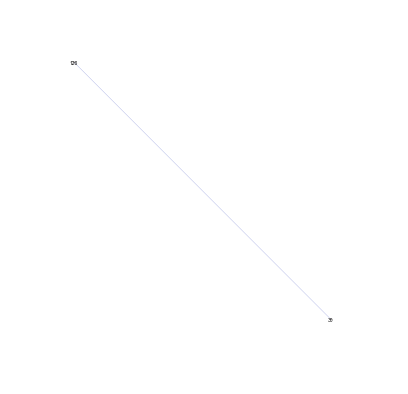

In [6]:
edges = rideshare_RG.edges()
print len(edges)
print edges

degrees = nx.degree(rideshare_RG)
centralities= nx.degree_centrality(rideshare_RG)
#print degrees
node_sizes = [i*0.5 for i in degrees.values()]
#print rideshare_RG.neighbors('1276')

#print rideshare_RG['1141']['106']['T']
weights = [(rideshare_RG[u][v]['saving']/10) for u,v in edges]
colors = plt.cm.coolwarm(np.log(weights))

plt.figure(figsize=(5,5))
P = nx.spring_layout(rideshare_RG, k=1,);
nx.draw(rideshare_RG, pos=P, node_size=node_sizes, width=weights, node_color='#f7cac9', edge_color = colors);
nx.draw_networkx_labels(rideshare_RG,pos=P,font_size=5); # semicolon suppresses output

In [188]:
### 4. Constructed the shared_trip graph, using nodes for trips and edges for shared trips
shared_RG = nx.Graph()
list_shared=[]
saved_value=[]
shared = rideshare_RG.edges()
trips = rideshare_RG.nodes()
match={}
for trip_i in trips:
    if trip_i not in list_shared:
        neighbors=rideshare_RG.neighbors(trip_i)
        dict_saved={}
        tmp_j = []
        for trip_j in neighbors:
            if trip_j not in list_shared:
                tmp_j.append(trip_j)
        #print '**tmp_j:',tmp_j
        if len(tmp_j)>=2:
            for trip_j in tmp_j:
                tmp_saving = rideshare_RG[trip_i][trip_j]['saving']
                dict_saved[trip_j]= tmp_saving                    
            trip2 = max(dict_saved.iteritems(), key=operator.itemgetter(1))[0]
            list_shared.append(trip2)
            list_shared.append(trip_i)
            saved_value.append(rideshare_RG[trip_i][trip2]['saving'])
            #print '>2,','i',trip_i,'j:',trip2            
        elif len(tmp_j) == 1:
            if tmp_j[0] not in list_shared:
                trip2= tmp_j[0]
                list_shared.append(trip2)
                list_shared.append(trip_i)
                saved_value.append(rideshare_RG[trip_i][trip2]['saving'])
            else:
                trip2= None
        else:
            trip_i = None
            trip2= None
    else:
        trip_i= None
        trip2= None
            #print '<2,','i',trip_i,'j:',trip2
    #print 'i',trip_i,'j',trip2, len(list_shared), len(saved_value), '\n'
    
    if trip_i != None and trip2 != None:        
        shared_attr = rideshare_RG[trip_i][trip2]
        shared_RG.add_edge(*(trip_i,trip2), attr_dict= shared_attr)
        
print list_shared,'\n',saved_value,'\n'      

[u'1026', u'1559', u'954', u'165', u'1347', u'1942', u'1873', u'1941', u'1734', u'624', u'1032', u'345', u'486', u'340', u'1756', u'341', u'1260', u'342', u'1327', u'1520', u'1054', u'812', u'291', u'813', u'382', u'348', u'333', u'349', u'1250', u'817', u'606', u'1545', u'1870', u'1798', u'689', u'719', u'1388', u'1622', u'542', u'717', u'922', u'716', u'248', u'715', u'987', u'1251', u'258', u'713', u'1180', u'1795', u'240', u'710', u'853', u'421', u'1396', u'1492', u'1515', u'1494', u'1626', u'1495', u'951', u'914', u'1412', u'1395', u'1476', u'1994', u'1024', u'1069', u'1449', u'1702', u'1659', u'1703', u'1418', u'1704', u'1903', u'1705', u'781', u'1707', u'1890', u'1708', u'684', u'1060', u'1292', u'1065', u'1170', u'1064', u'232', u'1067', u'1534', u'1529', u'861', u'298', u'456', u'299', u'146', u'296', u'1718', u'1666', u'1477', u'1665', u'1717', u'1061', u'569', u'1543', u'1117', u'1087', u'123', u'1129', u'547', u'592', u'1448', u'1083', u'756', u'594', u'2023', u'597', u'105

426
(u'1868', u'1841')


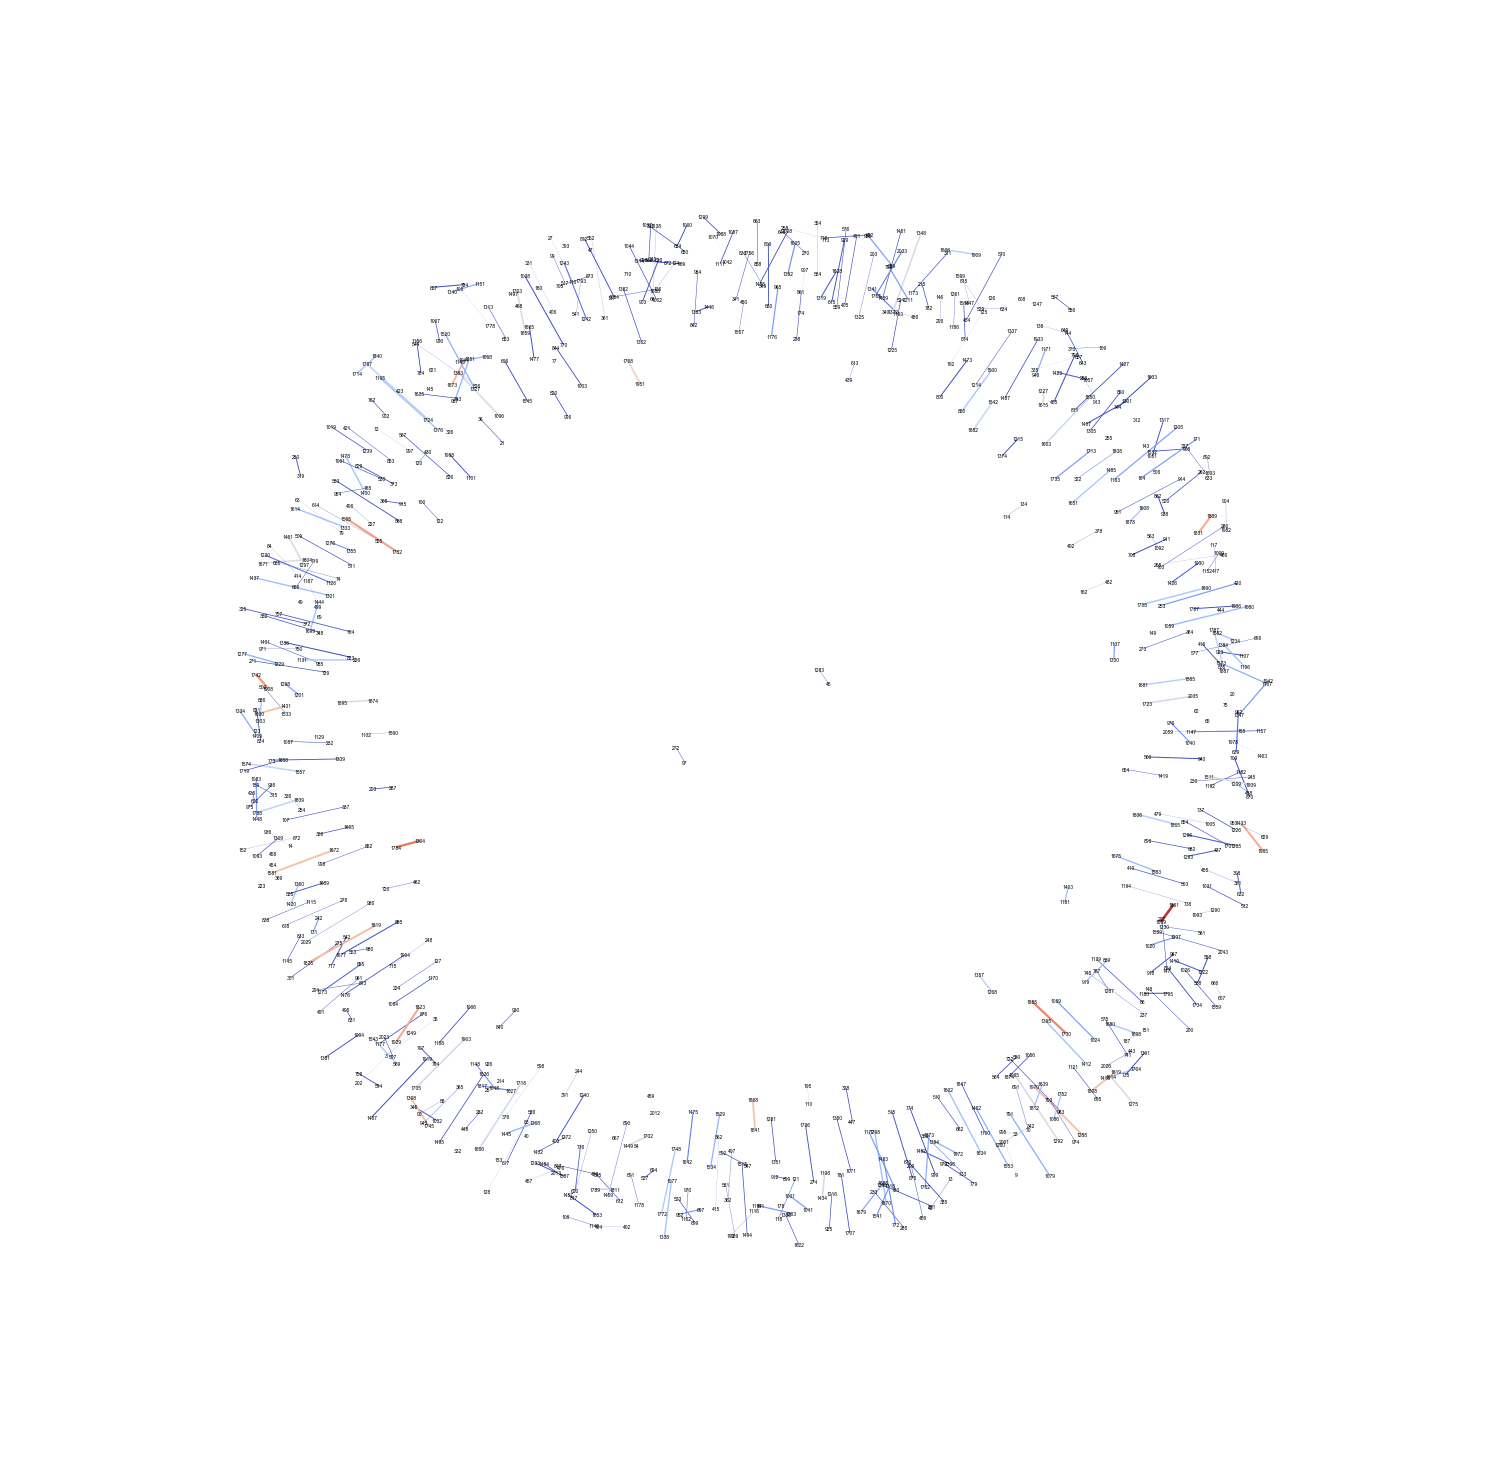

In [197]:
edges = shared_RG.edges()
print len(edges)
print edges[1]
#print rideshare_RG['1141']['106']['T']
weights = [(shared_RG[u][v]['saving']/10) for u,v in edges]
colors = plt.cm.coolwarm(np.log(weights))

plt.figure(figsize=(20,20))
P = nx.spring_layout(shared_RG, dim=2, k=0.1, pos=None, fixed=None, iterations=50, weight='weight', scale=1.0)
nx.draw(shared_RG, pos=P, node_size=0, width=weights, node_color='#b2b2b2', edge_color = colors);
nx.draw_networkx_labels(shared_RG,pos=P,font_size =5); # semicolon suppresses output

In [204]:
dict_Count=Counter(list_shared)
#print dict_Count.values()
print len(dict_Count.values())
print len(list_shared)
print len(saved_value)
print sum(saved_value)

852
852
426
3292.37559886


In [213]:
### 5. Constructed the new_RG graph
new_RG = nx.Graph()
OD_RG = nx.Graph()
for u,v in shared_RG.edges():
    if type(u)!= int and type (v)!= int:
        #print shared_RG[u][v]
        od1= rideshare_RG.node[u]['path']
        od2= rideshare_RG.node[v]['path']
        o1= od1[0]
        d1= od1[-1]
        o2= od2[0]
        d2= od2[-1]   
        #print rideshare_RG.node[u], o1, d1,od2, o2, d2
        OD_RG.add_edge(*(o1,d1), attr_dict= rideshare_RG.node[u])
        OD_RG.add_edge(*(o2,d2), attr_dict= rideshare_RG.node[v])

        tmp_route=shared_RG[u][v]['route']
        shared_attr = shared_RG[u][v]
        #print shared_attr
        #print tmp_route
        for i in range(len(tmp_route)):
            if i < len(tmp_route)-1:
                node1=tmp_route[i]
                node2=tmp_route[i+1]
                new_RG.add_edge(*(node1,node2), attr_dict= shared_attr)
loc_new={}
for node_index in new_RG.nodes():
    ##print node_index
    loc_new[node_index] = RG.node[node_index]["coordinate"]    
loc_OD={}
for node_index in OD_RG.nodes():
    ##print node_index
    loc_OD[node_index] = RG.node[node_index]["coordinate"]

In [267]:
edges = new_RG.edges()
print len(edges)
print edges[1]
#print rideshare_RG['1141']['106']['T']
weights = [(new_RG[u][v]['Saving']/2) for u,v in edges]
colors = plt.cm.RdBu(np.log(weights))

plt.figure(figsize=(40,40))
nx.draw(RG, pos=loc_dict, node_size=0, width=0.5, node_color='#bccad6', edge_color = '#bccad6');
nx.draw(new_RG, pos=loc_new, node_size=0, width=weights, node_color='#d96459', edge_color = colors);
nx.draw(OD_RG, pos=loc_OD, node_size=1, width=0.5, node_color='#ff6f69', edge_color = '#ff6f69');

4187
(8195, 6670)


KeyError: 'Saving'